In [ ]:
%load_ext autoreload
%autoreload 2

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import scipy 

import glob

from neurolib.models import aln

import neurolib.utils.loadData as ld
import neurolib.utils.functions as func
import neurolib.utils.fitparams as fp

# sett dpi for notebooks on server
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['savefig.dpi'] = 600
plt.rcParams['image.cmap'] = 'plasma'

# Single node simulation

In [35]:
alnModel = aln.ALNModel(Cmat = [])
alnModel.params = fp.loadpoint(alnModel.params, 'A2', reload_params=True)
alnModel.params['duration'] = 20.0*1000
alnModel.params['sigma_ou'] = 0.1
alnModel.chunkSize = 4000
alnModel.saveAllActivity = True
alnModel.simulateBOLD = True
alnModel.run()

(0, 2000)

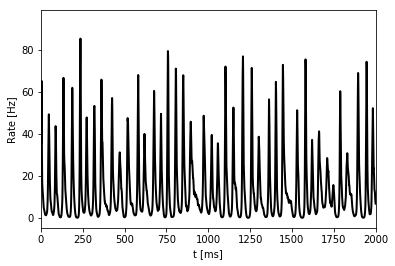

In [48]:
plt.plot(alnModel.t, alnModel.rates_exc.T, lw=2, c='k')
plt.xlabel("t [ms]")
plt.ylabel("Rate [Hz]")
plt.xlim(0, 2000)

## BOLD model

In [38]:
# This block demonstrates how the BOLDModel class is interfaced 
# This is also builtin into ALNModel, as demonstrated later

In [39]:
from neurolib.models import bold

In [40]:
boldModel = bold.BOLDModel(alnModel.params['N'], alnModel.params['dt'])

In [41]:
boldModel.run(alnModel.rates_exc)

Text(0, 0.5, 'BOLD activity')

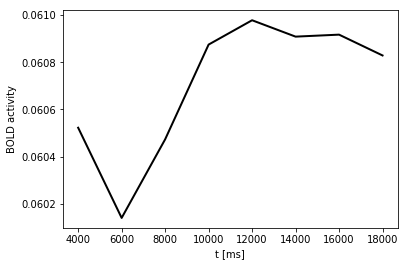

In [47]:
plt.plot(boldModel.t_BOLD[2:], boldModel.BOLD[:,2:].T, lw=2, c='k')
plt.xlabel("t [ms]")
plt.ylabel("BOLD activity")

# Whole brain model

In [51]:
# Load structural connectivity datasets
CmatFilenames = glob.glob("../../interareal/data/greifswald_data/NAP_*/SC/Unnormalized/DTI_CM.mat")
Cmat = ld.loadDataset(CmatFilenames, key='sc')
# Del
DmatFilenames = glob.glob("../../interareal/data/greifswald_data/NAP_*/SC/Unnormalized/DTI_LEN.mat")
Dmat = ld.loadDataset(DmatFilenames, key='len')

# Load BOLD resting-state functional connectivity matrices for brain network fitting
BOLDFilenames = glob.glob("../../interareal/data/greifswald_data/NAP_*/FC/TC.mat")
FCs = ld.loadDataset(BOLDFilenames, key='tc', average=False, apply_function=func.fc)
FCDs = ld.loadDataset(BOLDFilenames, key='tc', average=False, \
                      apply_function=func.fcd, apply_function_kwargs={"stepsize" : 10})

In [52]:
alnModel = aln.ALNModel(Cmat = Cmat, Dmat = Dmat, simulateBOLD=True)

In [53]:
# load default parameters
alnModel.params = fp.load_pars_noadapt(alnModel.params, reloadDefaults=False)

# 19/09/13 fits
load_set = 2
if load_set == 1:
    parnames = ['mue_ext_mean', 'mui_ext_mean', 'sigma_ou', 'Ke_gl', 'signalV']
    parvals = [1.208, 1.454, 0.1226, 298.0, 20.38]
    for p, v in zip(parnames, parvals):
        alnModel.params[p] = v    
elif load_set == 2:
    parnames = ['mue_ext_mean', 'mui_ext_mean', 'sigma_ou', 'Ke_gl', 'signalV']
    parvals = [1.581, 1.588, 0.08757, 184.1, 33.04]
    for p, v in zip(parnames, parvals):
        alnModel.params[p] = v

In [54]:
alnModel.params['duration'] = 20*1000

In [55]:
alnModel.run()

Text(0.5, 0, 't [ms]')

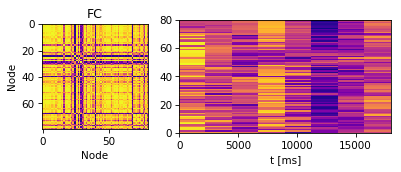

In [60]:
# Plot functional connectivity and BOLD timeseries (z-scored)
fig, axs = plt.subplots(1, 2, figsize=(6, 2), dpi=75, gridspec_kw={'width_ratios' : [1, 2]})
axs[0].imshow(func.fc(alnModel.BOLD[:, 5:]))
axs[1].imshow(scipy.stats.mstats.zscore(alnModel.BOLD[:, 2:], axis=1), aspect='auto', extent=[0, alnModel.t_BOLD[-1], 0, alnModel.params['N']]);

axs[0].set_title("FC")
axs[0].set_xlabel("Node")
axs[0].set_ylabel("Node")

axs[1].set_xlabel("t [ms]")

In [61]:
scores = []
for i in range(len(FCs)):
    fc_score = func.matrix_correlation(func.fc(alnModel.BOLD[:, 5:]), FCs[i])
    scores.append(fc_score)
    print("Subject {}: {:.2f}". format(i, fc_score))
print("Mean FC/FC correlation: {:.2f}".format(np.mean(scores)))

Subject 0: 0.26
Subject 1: 0.38
Subject 2: 0.38
Subject 3: 0.32
Subject 4: 0.42
Subject 5: 0.44
Subject 6: 0.27
Subject 7: 0.42
Subject 8: 0.36
Subject 9: 0.34
Subject 10: 0.42
Mean FC/FC correlation: 0.36
